it's Leo!
it's Leo!
it's Leo!
it's Leo!


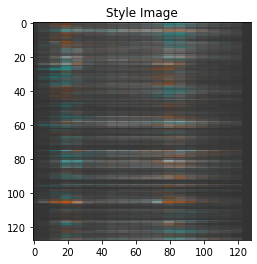

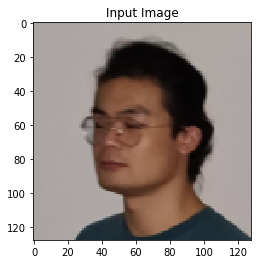

Building the style transfer model..


/Users/Leo/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/Leo/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Optimizing..
run [50]:
Style Loss : 126.885147 Content Loss: 16.008127

run [100]:
Style Loss : 51.760303 Content Loss: 17.011446

run [150]:
Style Loss : 32.745167 Content Loss: 17.004879

run [200]:
Style Loss : 22.948750 Content Loss: 16.857471

run [250]:
Style Loss : 15.657953 Content Loss: 16.744137

run [300]:
Style Loss : 11.363839 Content Loss: 16.520058



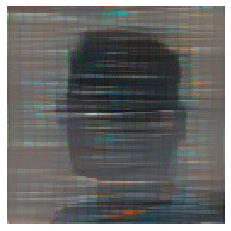

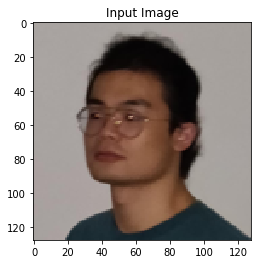

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 120.034760 Content Loss: 15.523007

run [100]:
Style Loss : 47.639637 Content Loss: 16.508579

run [150]:
Style Loss : 29.991993 Content Loss: 16.478821

run [200]:
Style Loss : 20.964821 Content Loss: 16.398956

run [250]:
Style Loss : 14.266054 Content Loss: 16.289392

run [300]:
Style Loss : 9.694866 Content Loss: 16.166958



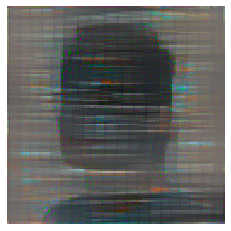

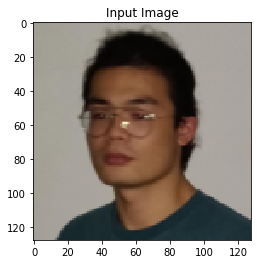

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 119.769928 Content Loss: 15.874763

run [100]:
Style Loss : 44.036247 Content Loss: 16.998440

run [150]:
Style Loss : 27.265772 Content Loss: 16.747042

run [200]:
Style Loss : 19.103521 Content Loss: 16.597750

run [250]:
Style Loss : 14.115403 Content Loss: 16.424887

run [300]:
Style Loss : 9.795822 Content Loss: 16.312544



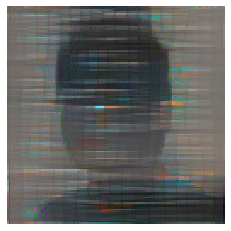

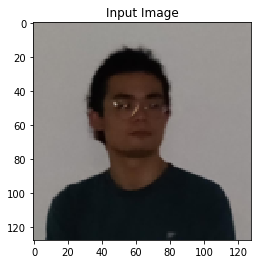

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 91.369705 Content Loss: 14.824395

run [100]:
Style Loss : 37.332680 Content Loss: 16.004932

run [150]:
Style Loss : 21.426884 Content Loss: 16.010170

run [200]:
Style Loss : 15.293593 Content Loss: 15.679641

run [250]:
Style Loss : 11.377833 Content Loss: 15.347843

run [300]:
Style Loss : 8.901199 Content Loss: 15.124834



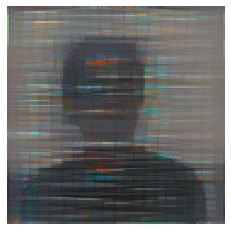

style transfer is done


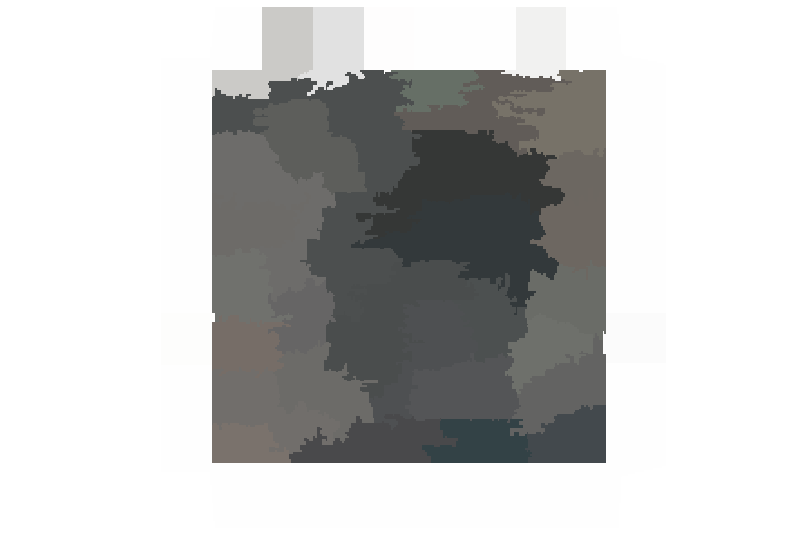

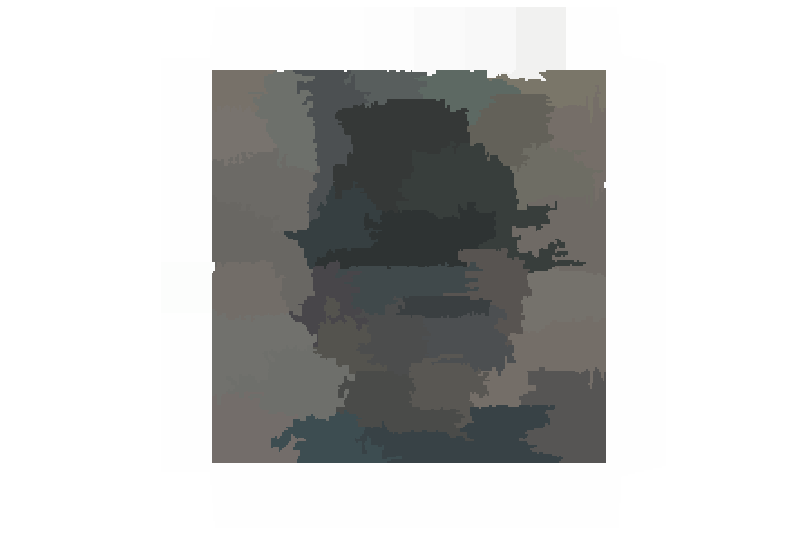

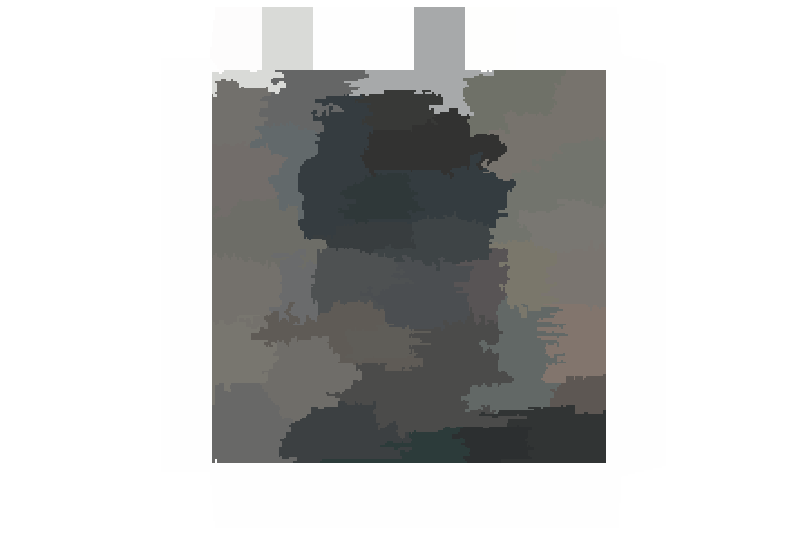

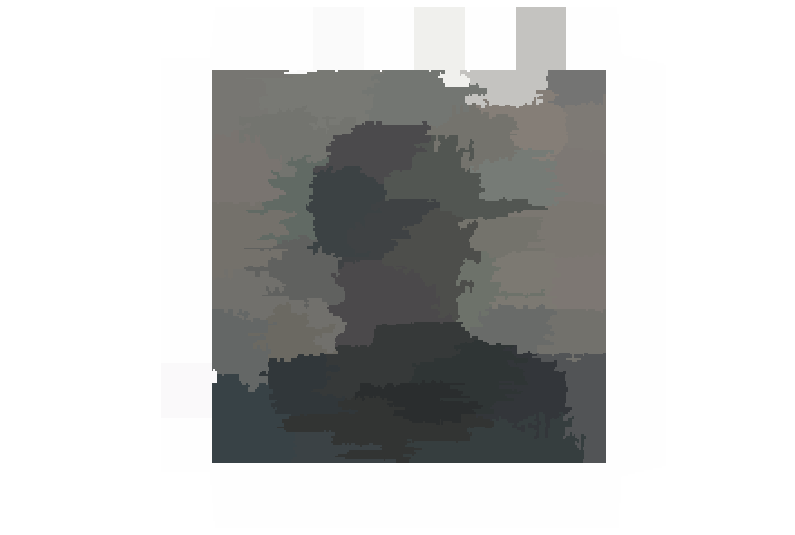

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Aug 31 09:16:05 2019

@author: Leo
"""
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
import torchvision.models as models

import copy
from PIL import Image
from PIL import ImageFilter
from skimage import io
import skimage.color as color
import skimage.filters as filters
import skimage.segmentation as seg

import face_recognition

person1_image = face_recognition.load_image_file("./known_people/person1.jpeg")

person2_image = face_recognition.load_image_file("./known_people/person2.jpeg")


file_num = 5
recognized_index=0

for i in range(1,file_num):
    unknown_image = face_recognition.load_image_file("./unknown_pictures/unknown"+str(i)+".jpeg")
    
    try:
        leo_face_encoding = face_recognition.face_encodings(person1_image)[0]
        pb_face_encoding = face_recognition.face_encodings(person2_image)[0]
        unknown_face_encoding = face_recognition.face_encodings(unknown_image)[0]
    except IndexError:
        print("I wasn't able to locate any faces in at least one of the images")
        quit()
        
    known_faces = [
            leo_face_encoding,
            pb_face_encoding
            ]
    
    #results is an array of True/False telling if the unknown face matched anyone in the known_faces array
    
    results = face_recognition.compare_faces(known_faces, unknown_face_encoding)
    
    if(results[0] == True):
        image = Image.open("./unknown_pictures/unknown"+str(i)+".jpeg")
        image.save("leo"+str(recognized_index)+".jpg")
        recognized_index += 1
        print("it's Leo!")
    else:
        print("unknown faces")
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor
        
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    
# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
   
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img
    
style='style7'
style_img = image_loader(style+".jpg")

content_path = []
content_img = []
for i in range(0,recognized_index):
    content_path.append("leo"+str(i)+".jpg")
    content_img.append(image_loader(content_path[i]))
    assert style_img.size() == content_img[i].size(), \
    "we need to import style and content images of the same size"
    
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()
plt.figure()
imshow(style_img, title='Style Image')
#print("test")
    
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

for i in range(0,recognized_index):
    input_img = content_img[i].clone()
    # if you want to use white noise instead uncomment the below line:
    # input_img = torch.randn(content_img.data.size(), device=device)

    # add the original input image to the figure:
    plt.figure()
    imshow(input_img, title='Input Image')

    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img[i], style_img, input_img)

    plt.figure()
    final_image = output.cpu().clone()  # we clone the tensor to not do changes on it
    final_image = final_image.squeeze(0)      # remove the fake batch dimension
    final_image = unloader(final_image)
    plt.imshow(final_image)
    plt.axis('off')
    plt.savefig(style+"/final_image"+str(i)+".jpg")
    plt.pause(0.001) 
    # sphinx_gallery_thumbnail_number = 4
    plt.ioff()
    plt.show()

print("style transfer is done")

def image_show(image, nrows=1,ncols=1,cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,14))
    ax.imshow(image,cmap='gray')
    ax.axis('off')
    return fig,ax

for i in range(0,recognized_index):
    image = io.imread(style+'/final_image'+str(i)+'.jpg')
    image_gray = color.rgb2gray(image)
    image_slic = seg.slic(image, n_segments=155)
    
    fig,ax = image_show(color.label2rgb(image_slic, image, kind='avg'))
    fig.savefig(style+'/slic'+str(i)+'.jpg')
    
    image_1 = Image.open('slic'+str(i)+'.jpg')
    edge_1 = image_1.filter(ImageFilter.FIND_EDGES)
    edge_1.save(style+'/edged_slic'+str(i)+'.jpg')